In [ ]:
import SimpleITK as sitk
import torch

import numpy as np
from utils import trim_state_dict_name

%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
latent_dim = 1024
save_step = 80000
batch_size = 1
img_size = 256
num_class = 0
exp_name = "a-inter"

## Load model

In [4]:
if img_size == 256:
    from models.Model_HA_GAN_256 import Generator, Encoder
elif img_size == 128:
    from models.Model_HA_GAN_128 import Generator, Encoder
print("a")
G = Generator(mode='eval', latent_dim=latent_dim, num_class=num_class).cuda()
print("b")

# E = Encoder().cuda()
#Sub_E = Sub_Encoder(latent_dim=latent_dim).cuda()
ckpt_path = "/home/mahshid/Desktop/LUNA_res/crf-gan-res/G_iter80000.pth"
# ckpt_path = '/home/mahshid/Desktop/alpha_res/G_iter80000.pth'
#ckpt_path = "./checkpoint/"+exp_name+"/G_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)['model']
ckpt = trim_state_dict_name(ckpt)
G.load_state_dict(ckpt)
print("G loaded")
"""
ckpt_path = "/home/mahshid/Desktop/Projects/HAGAN/HA-GAN/COPD_HA_GAN_pretrained_LUNG/E_iter80000.pth"
# ckpt_path = "./checkpoint/"+exp_name+"/E_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)['model']
ckpt = trim_state_dict_name(ckpt)
E.load_state_dict(ckpt)
print("e")
ckpt_path = "/home/mahshid/Desktop/Projects/HAGAN/HA-GAN/COPD_HA_GAN_pretrained_LUNG/Sub_E_iter80000.pth"
#ckpt_path = "./checkpoint/"+exp_name+"/Sub_E_iter"+str(save_step)+".pth"
ckpt = torch.load(ckpt_path)['model']
ckpt = trim_state_dict_name(ckpt)
Sub_E.load_state_dict(ckpt)
print("f")
"""
print(exp_name, save_step, "step weights loaded.")
del ckpt

G = G.cuda()
# E = E.cuda()
# Sub_E = Sub_E.cuda()

G.eval()
# E.eval()
# Sub_E.eval()

torch.cuda.empty_cache()

a
b


RuntimeError: Error(s) in loading state_dict for Generator:
	Unexpected key(s) in state_dict: "sub_G.tp_conv1.weight", "sub_G.tp_conv1.bias", "sub_G.bn1.weight", "sub_G.bn1.bias", "sub_G.tp_conv2.weight", "sub_G.tp_conv2.bias", "sub_G.bn2.weight", "sub_G.bn2.bias", "sub_G.tp_conv3.weight", "sub_G.tp_conv3.bias". 

## Random generation

In [4]:
from skimage.transform import resize
def post_process_brain(x_pred):
    x_pred = resize(x_pred, (256-90,256-40,256-40), mode='constant', cval=0.)
    x_canvas = np.zeros((256,256,256))
    x_canvas[50:-40,20:-20,20:-20] = x_pred
    x_canvas = np.flip(x_canvas,0)
    return x_canvas

def _itensity_normalize(volume):       
    pixels = volume[volume > 0]
    mean = pixels.mean()
    std  = pixels.std()
    out = (volume - mean)/std
    return out

In [7]:
with torch.no_grad():
    z_rand = torch.randn((batch_size, latent_dim)).cuda()
    x_rand = G(z_rand,0)
    x_rand = x_rand.detach().cpu().numpy()
    # todo khodam comment kardam
    x_rand = 0.5*x_rand+0.5 # rescale intensity to [0,1]

    x_rand = x_rand[0,0,:,:,:]

In [18]:
# todo khodam ezafe kardm
x_rand = _itensity_normalize(x_rand)
x_rand = post_process_brain(x_rand)

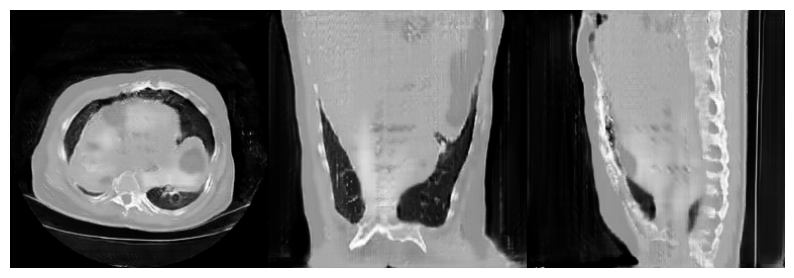

In [11]:
slice_idx = [127,127,127]
#slice_x = np.flip(x_rand[slice_idx[0],:,:],0)
#slice_y = np.flip(x_rand[:,slice_idx[1],:],0)
#slice_z = np.flip(x_rand[:,:,slice_idx[2]],0)
slice_x = x_rand[slice_idx[0],:,:]
slice_y = x_rand[:,slice_idx[1],:]
slice_z = x_rand[:,:,slice_idx[2]]
result = np.concatenate([slice_x,slice_y, slice_z],1)
plt.figure(figsize=(10,5))
plt.imshow(result, cmap="gray")
plt.axis('off')
plt.show()

### Save in NIFTI

In [24]:
import nibabel as nib

low_threshold = -1024
high_threshold = 600

x_rand_nifti = x_rand * (high_threshold-low_threshold) + low_threshold # rescale to [low_threshold, high_threshold]
x_rand_nifti = x_rand_nifti.astype(np.int16)

x_rand_nifti = nib.Nifti1Image(x_rand_nifti.transpose((2,1,0)),affine = np.eye(4))
nib.save(x_rand_nifti, "/home/mahshid/Desktop/x_rand_nifti.nii.gz")

## save N results

In [12]:
N = 50
low_threshold = -1024
high_threshold = 600

from PIL import Image as im
from matplotlib import image, cm
import nibabel as nib

for i in range(N):

    # generate image
    with torch.no_grad():
        z_rand = torch.randn((batch_size, latent_dim)).cuda()
        x_rand = G(z_rand,0)
        x_rand = x_rand.detach().cpu().numpy()
        x_rand = 0.5*x_rand+0.5 # rescale intensity to [0,1]
        x_rand = x_rand[0,0,:,:,:]

    # slice it in all axis
    slice_idx = [127,127,127]
    slice_x = x_rand[slice_idx[0],:,:]
    slice_y = x_rand[:,slice_idx[1],:]
    slice_z = x_rand[:,:,slice_idx[2]]
    result = np.concatenate([slice_x,slice_y, slice_z],1)

    # generate zoom in regions
    zoom_result = np.concatenate([slice_x[10:128-20,128:-30],slice_y[10:128-20,128:-30], slice_z[10:128-20,128:-30]], 1)
    image1 = im.fromarray(np.uint8(cm.gray(result)*255))
    image2 = im.fromarray(np.uint8(cm.gray(zoom_result)*255)).resize(image1.size)
    res_withzoom = im.new("RGB", (image1.size[0], image1.size[1]*2))
    res_withzoom.paste(image1,(0,0))
    res_withzoom.paste(image2,(0, image1.size[1]))

    # save NIFTI format
    x_rand_nifti = x_rand * (high_threshold-low_threshold) + low_threshold # rescale to [low_threshold, high_threshold]
    x_rand_nifti = x_rand_nifti.astype(np.int16)
    x_rand_nifti = nib.Nifti1Image(x_rand_nifti.transpose((2,1,0)),affine = np.eye(4))
    nib.save(x_rand_nifti, f"/home/mahshid/Desktop/LUNA_res/crf-gan-LUNA/{i}.nii.gz")

    # save png format
    image.imsave(f'/home/mahshid/Desktop/LUNA_res/crf-gan-LUNA/gray{i}.png', result, cmap=cm.gray)
    # image.imsave(f'/home/mahshid/Desktop/CRF-GAN-RES/pic/rgb/{i}.png', result)
    # res_withzoom.save(f'/home/mahshid/Desktop/LUNA_res/crf-gan-LUNA/withzoom{i}.png', "PNG", cmap=cm.gray)
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


## Zoom-in region

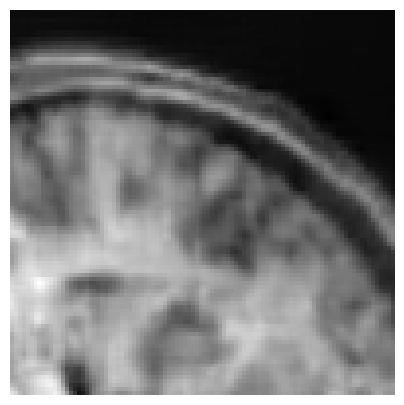

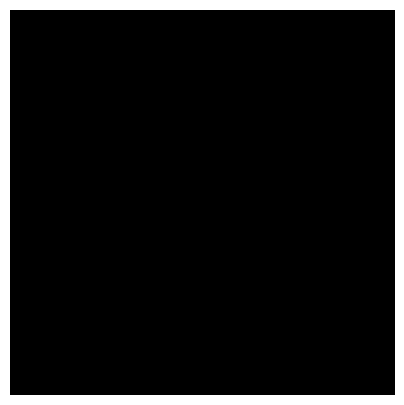

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(slice_y[10:128-20,128:-30], cmap="gray")
plt.axis('off')
plt.show()

slice_y_threshold = slice_y[10:128-20,128:-30].copy()
slice_y_threshold = np.clip(slice_y_threshold, 0., (-250+1024)/(600+1024))

plt.figure(figsize=(5,5))
plt.imshow(slice_y_threshold, cmap="gray")
plt.axis('off')
plt.show()

## View in 3D

In [24]:
pip install holoviews

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
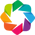

In [8]:
import holoviews as hv
from holoviews import opts
import xarray as xr
hv.extension('bokeh')

In [9]:
class Image:
    def __init__(self, image_array):
        self.image_array=image_array
        self.xr=None
    def get_xr(self):
        if self.xr is not None:
            return self.xr
        else:
            self.xr=xr.Dataset({'image': (['x','y','z'], self.image_array)},
                      coords={
                          'x':np.arange(img_size),
                          'y':np.arange(img_size),
                          'z':np.arange(img_size)
                      })
            return self.xr
        
def plot_on_grid(image):
    hv_image = hv.Dataset(image.get_xr())
    layout = (hv_image.to(hv.Image, ['y', 'x'], groupby=['z'], dynamic=True).opts(tools=['hover'])
              + hv_image.to(hv.Image, ['z', 'x'], groupby=['y'], dynamic=True).opts(tools=['hover'])
              + hv_image.to(hv.Image, ['z', 'y'], groupby=['x'], dynamic=True).opts(tools=['hover']))

    layout.opts(
        opts.Image(width=300, height=300, cmap="gray"))
    return layout


In [10]:
x_rand_img = Image(x_rand)
plot_on_grid(x_rand_img)

:Layout
   .DynamicMap.I   :DynamicMap   [z]
      :Image   [y,x]   (image)
   .DynamicMap.II  :DynamicMap   [y]
      :Image   [z,x]   (image)
   .DynamicMap.III :DynamicMap   [x]
      :Image   [z,y]   (image)